# Overview

In this notebook, we will build a predictive model for the Prosper loan data. We will import the processed data from our previous notebook [here](http://localhost:8888/notebooks/Forecasting%20credit%20risk%20using%20logistic%20regression.ipynb#ProsperScore).

Our goal is to build perform a binary classification of the loan default/non-default variables using logistic regression.

Note that when doing credit risk modeling, we want to minimize the risk, but we still want to give out loans because that's how lenders make money. We will look at possible scenarios of how to meet the needs of lenders.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import (confusion_matrix, classification_report)

import pickle

### Loading the Data

In [2]:
x_train = pd.read_csv('loan_data_inputs_train.csv')
y_train = pd.read_csv('loan_data_targets_train.csv')
x_test = pd.read_csv('loan_data_inputs_test.csv')
y_test = pd.read_csv('loan_data_targets_test.csv')

In [3]:
print("Train data:", x_train.shape, y_train.shape)
print("Test data:", x_test.shape, y_test.shape)

Train data: (40423, 77) (40423, 1)
Test data: (13475, 77) (13475, 1)


#### Reshape the target datasets

In [4]:
y_train = y_train.values.reshape(-1,)
y_test = y_test.values.reshape(-1,)

In [5]:
#print new shape
print("Train data:", x_train.shape, y_train.shape)
print("Test data:", x_test.shape, y_test.shape)

Train data: (40423, 77) (40423,)
Test data: (13475, 77) (13475,)


In [6]:
#a look at few rows of input train data
x_train.head()

,IncomeRange,IncomeVerifiable,IsBorrowerHomeowner,DebtToIncomeRatio,AvailableBankcardCredit,EmploymentStatus,LoanStatus,Term,LoanOriginalAmount,ProsperRating (Alpha),...,DebtToIncomeRatio:0.244-0.296,DebtToIncomeRatio:0.296-0.4,DebtToIncomeRatio>0.4,AvailableBankcardCreditFactor,AvailableBankcardCredit:<8.5k,AvailableBankcardCredit:8.5k-15.5k,AvailableBankcardCredit:15.5k-21k,AvailableBankcardCredit:21k-25.5k,AvailableBankcardCredit:25.5k-30k,AvailableBankcardCredit>30k
0,"$25,000-49,999",True,False,0.07,1645.0,Employed,Chargedoff,60,3500,E,...,0,0,0,"(-498.374, 9967.48]",1,0,0,0,0,0
1,"$100,000+",True,True,0.23,10704.0,Employed,Current,60,15000,A,...,0,0,0,"(9967.48, 19934.96]",0,1,0,0,0,0
2,"$100,000+",True,False,0.18,24063.0,Employed,Current,60,25000,A,...,0,0,0,"(19934.96, 29902.44]",0,0,0,1,0,0
3,"$50,000-74,999",True,False,0.20,47304.0,Employed,Current,36,4000,D,...,0,0,0,"(39869.92, 49837.4]",0,0,0,0,0,1
4,"$50,000-74,999",True,False,0.12,2630.0,Employed,Current,60,15000,C,...,0,0,0,"(-498.374, 9967.48]",1,0,0,0,0,0


In [7]:
#a look at few rows of input test data
x_test.head()

,IncomeRange,IncomeVerifiable,IsBorrowerHomeowner,DebtToIncomeRatio,AvailableBankcardCredit,EmploymentStatus,LoanStatus,Term,LoanOriginalAmount,ProsperRating (Alpha),...,DebtToIncomeRatio:0.244-0.296,DebtToIncomeRatio:0.296-0.4,DebtToIncomeRatio>0.4,AvailableBankcardCreditFactor,AvailableBankcardCredit:<8.5k,AvailableBankcardCredit:8.5k-15.5k,AvailableBankcardCredit:15.5k-21k,AvailableBankcardCredit:21k-25.5k,AvailableBankcardCredit:25.5k-30k,AvailableBankcardCredit>30k
0,"$25,000-49,999",True,False,0.35,0.0,Employed,Current,36,2500,HR,...,0,1,0,"(-360.0, 7200.0]",1,0,0,0,0,0
1,"$1-24,999",False,False,NaN,115.0,Self-employed,Current,60,12000,D,...,0,0,0,"(-360.0, 7200.0]",1,0,0,0,0,0
2,"$50,000-74,999",True,True,0.42,12145.0,Employed,Current,36,15000,C,...,0,0,1,"(7200.0, 14400.0]",0,1,0,0,0,0
3,"$75,000-99,999",True,False,0.13,200.0,Employed,Current,36,4000,B,...,0,0,0,"(-360.0, 7200.0]",1,0,0,0,0,0
4,"$75,000-99,999",True,False,0.18,378.0,Employed,Completed,36,4000,D,...,0,0,0,"(-360.0, 7200.0]",1,0,0,0,0,0


### Selecting the Features

#### input Training data

In [8]:
x_train.columns.values

array(['IncomeRange', 'IncomeVerifiable', 'IsBorrowerHomeowner',
       'DebtToIncomeRatio', 'AvailableBankcardCredit', 'EmploymentStatus',
       'LoanStatus', 'Term', 'LoanOriginalAmount',
       'ProsperRating (Alpha)', 'ProsperScore', 'BorrowerRate',
       'CreditScoreRange', 'IncomeRange:$0', 'IncomeRange:$1-24,999',
       'IncomeRange:$100,000+', 'IncomeRange:$25,000-49,999',
       'IncomeRange:$50,000-74,999', 'IncomeRange:$75,000-99,999',
       'IncomeRange:Not employed', 'EmploymentStatus:Employed',
       'EmploymentStatus:Full-time', 'EmploymentStatus:Not employed',
       'EmploymentStatus:Other', 'EmploymentStatus:Part-time',
       'EmploymentStatus:Retired', 'EmploymentStatus:Self-employed',
       'CreditScoreRange:Exceptional (800+)',
       'CreditScoreRange:Fair (600-679)',
       'CreditScoreRange:Good (680-739)',
       'CreditScoreRange:Very Good (740-799)', 'IncomeVerifiable:False',
       'IncomeVerifiable:True', 'IsBorrowerHomeowner:False',
       'IsBorrow

In [9]:
x_train_with_ref_cat = x_train[['IncomeRange:$0', 'IncomeRange:$1-24,999',
       'IncomeRange:$100,000+', 'IncomeRange:$25,000-49,999',
       'IncomeRange:$50,000-74,999', 'IncomeRange:$75,000-99,999',
       'IncomeRange:Not employed', 'EmploymentStatus:Employed',
       'CreditScoreRange:Exceptional (800+)',
       'CreditScoreRange:Fair (600-679)',
       'CreditScoreRange:Good (680-739)',
       'CreditScoreRange:Very Good (740-799)', 'IncomeVerifiable:False',
       'IncomeVerifiable:True', 'IsBorrowerHomeowner:False',
       'IsBorrowerHomeowner:True', 'ProsperRating (Alpha):A',
       'ProsperRating (Alpha):AA', 'ProsperRating (Alpha):B',
       'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D',
       'ProsperRating (Alpha):E', 'ProsperRating (Alpha):HR',
       'EmploymentStatus:Other__self_employed__full_time',
       'EmploymentStatus:Not_employed__part_time__retired', 'Term:12',
       'Term:36', 'Term:60', 'ProsperScore:1', 'ProsperScore:2-5',
       'ProsperScore:6-8', 'ProsperScore:9-11',
       'BorrowerRate:<0.111', 'BorrowerRate:0.111, 0.188',
       'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292',
       'BorrowerRate:>0.292',
       'LoanOriginalAmount:<7.5K', 'LoanOriginalAmount:7.5K-15K',
       'LoanOriginalAmount:15K-20.4K', 'LoanOriginalAmount:20.4K-24.3k',
       'LoanOriginalAmount>24.3k',
       'DebtToIncomeRatio:Missing', 'DebtToIncomeRatio:<0.088',
       'DebtToIncomeRatio:0.088-0.244', 'DebtToIncomeRatio:0.244-0.296',
       'DebtToIncomeRatio:0.296-0.4', 'DebtToIncomeRatio>0.4',
        'AvailableBankcardCredit:<8.5k',
       'AvailableBankcardCredit:8.5k-15.5k',
       'AvailableBankcardCredit:15.5k-21k',
       'AvailableBankcardCredit:21k-25.5k',
       'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]


#============================================================================================
#list of reference variable categories with lowest weight of evidience 

ref_categories = ['IncomeRange:$0', 'EmploymentStatus:Not_employed__part_time__retired','CreditScoreRange:Fair (600-679)',
                 'Term:60','IsBorrowerHomeowner:False','IncomeVerifiable:False',
                  'BorrowerRate:<0.111','ProsperRating (Alpha):HR','LoanOriginalAmount:<7.5K',
                  'DebtToIncomeRatio:<0.088', 'AvailableBankcardCredit:<8.5k','ProsperScore:1',
                 'EmploymentStatus:Not_employed__part_time__retired']

In [10]:
inputs_train = x_train_with_ref_cat.drop(ref_categories, axis = 1)
inputs_train.shape

(40423, 42)

In [11]:
sum(inputs_train.dtypes==int)

42

So we have 42 features in the input training data and are numeric, a desirable data type for our ML model.

#### Input Testing data

In [12]:
# Here, from the dataframe with inputs for testing, we keep the same variables that we used in our final PD model.


x_test_with_ref_cat = x_test[['IncomeRange:$0', 'IncomeRange:$1-24,999',
       'IncomeRange:$100,000+', 'IncomeRange:$25,000-49,999',
       'IncomeRange:$50,000-74,999', 'IncomeRange:$75,000-99,999',
       'IncomeRange:Not employed', 'EmploymentStatus:Employed',
       'CreditScoreRange:Exceptional (800+)',
       'CreditScoreRange:Fair (600-679)',
       'CreditScoreRange:Good (680-739)',
       'CreditScoreRange:Very Good (740-799)', 'IncomeVerifiable:False',
       'IncomeVerifiable:True', 'IsBorrowerHomeowner:False',
       'IsBorrowerHomeowner:True', 'ProsperRating (Alpha):A',
       'ProsperRating (Alpha):AA', 'ProsperRating (Alpha):B',
       'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D',
       'ProsperRating (Alpha):E', 'ProsperRating (Alpha):HR',
       'EmploymentStatus:Other__self_employed__full_time',
       'EmploymentStatus:Not_employed__part_time__retired', 'Term:12',
       'Term:36', 'Term:60', 'ProsperScore:1', 'ProsperScore:2-5',
       'ProsperScore:6-8', 'ProsperScore:9-11',
       'BorrowerRate:<0.111', 'BorrowerRate:0.111, 0.188',
       'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292',
       'BorrowerRate:>0.292',
       'LoanOriginalAmount:<7.5K', 'LoanOriginalAmount:7.5K-15K',
       'LoanOriginalAmount:15K-20.4K', 'LoanOriginalAmount:20.4K-24.3k',
       'LoanOriginalAmount>24.3k',
       'DebtToIncomeRatio:Missing', 'DebtToIncomeRatio:<0.088',
       'DebtToIncomeRatio:0.088-0.244', 'DebtToIncomeRatio:0.244-0.296',
       'DebtToIncomeRatio:0.296-0.4', 'DebtToIncomeRatio>0.4',
        'AvailableBankcardCredit:<8.5k',
       'AvailableBankcardCredit:8.5k-15.5k',
       'AvailableBankcardCredit:15.5k-21k',
       'AvailableBankcardCredit:21k-25.5k',
       'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]




ref_categories = ['IncomeRange:$0', 'EmploymentStatus:Not_employed__part_time__retired','CreditScoreRange:Fair (600-679)',
                 'Term:60','IsBorrowerHomeowner:False','IncomeVerifiable:False',
                  'BorrowerRate:<0.111','ProsperRating (Alpha):HR','LoanOriginalAmount:<7.5K',
                  'DebtToIncomeRatio:<0.088', 'AvailableBankcardCredit:<8.5k','ProsperScore:1',
                 'EmploymentStatus:Not_employed__part_time__retired']

In [13]:
inputs_test = x_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.shape

(13475, 42)

In [14]:
sum(inputs_train.dtypes==int)

42

In [15]:
(inputs_test.columns == inputs_train.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

So we have 42 features in the input testing data and all are numeric. We have also confirmed that the features n x_train==x_test

# PD Model Estimation

## Logistic Regression

In [16]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [17]:
def performance_report(model,X_true,y_true):
    """
    Function to generate classification report on a model
    INPUT: Model, true data sets, that is X_test & y_test data sets
    OUTPUT: Prints the f1 score, precision and recall for each output category
    """
    y_pred = model.predict(X_true)
    
    print(classification_report(y_true, y_pred))
   

In [18]:
def confusion_mat(model,X_true,y_true):
    y_pred = model.predict(X_true)
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

In [19]:
def confusion_mat_with_gridsearch(model,X_true,y_true):
    y_pred = model.best_estimator_.predict(X_true)
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

### Build Logistic regression pipeline

In [20]:
LogReg_pipeline = Pipeline([
    ('clf', LogisticRegression())
])



In [21]:
LogReg_pipeline.fit(inputs_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [22]:
#test the model
performance_report(LogReg_pipeline, inputs_test, y_test)

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       969
           1       0.93      1.00      0.96     12506

    accuracy                           0.93     13475
   macro avg       0.71      0.50      0.48     13475
weighted avg       0.90      0.93      0.89     13475



{'tn': 3, 'fp': 966, 'fn': 3, 'tp': 12503}

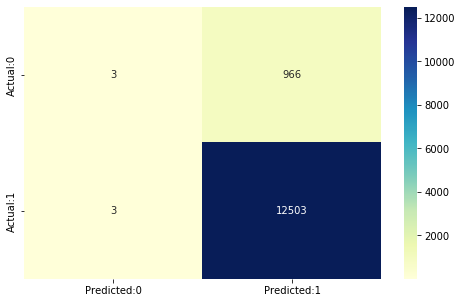

In [23]:
confusion_mat(LogReg_pipeline, inputs_test, y_test)

So we see here that our model predicts good borrowers with 93% precision, and bad borrowers with precision of 50%

### Improve the model

Before we use grid search, we want to know which independent variables contribute to predicting borrower default and which dont? The accepted approach is to check the statistical significance of coeeficients of each dummy variables. We look at P-value, then we will alter the fit model with newly selected features.

### Build a Logistic Regression Model with P-Values


In [24]:
inputs_train['intercept']= 1
logit_mod =sm.Logit(y_train,inputs_train)

#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.222125
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Results: Logit
=================================================================================================
Model:                          Logit                      Pseudo R-squared:           0.129     
Dependent Variable:             y                          AIC:                        18043.9306
Date:                           2022-03-09 04:41           BIC:                        18414.0382
No. Observations:               40423                      Log-Likelihood:             -8979.0   
Df Model:                       42                         LL-Null:                    -10308.   
Df Residuals:                   40380                      LLR p-value:                0.0000    
Converged:                      1.0000                     Scale:                      1.0000    
No. Iterations:                 8.0000                                                           
-------------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------------
IncomeRange:$1-24,999                             0.0694   0.7172   0.0968 0.9229 -1.3363  1.4751
IncomeRange:$100,000+                             0.9817   0.7177   1.3678 0.1714 -0.4250  2.3884
IncomeRange:$25,000-49,999                        0.2258   0.7153   0.3157 0.7522 -1.1762  1.6278
IncomeRange:$50,000-74,999                        0.5893   0.7159   0.8231 0.4105 -0.8139  1.9924
IncomeRange:$75,000-99,999                        0.7496   0.7172   1.0453 0.2959 -0.6560  2.1553
IncomeRange:Not employed                          0.3682   0.8274   0.4450 0.6563 -1.2535  1.9899
EmploymentStatus:Employed                         0.3258   0.3977   0.8194 0.4126 -0.4536  1.1053
CreditScoreRange:Exceptional (800+)              -0.2824   0.1528  -1.8483 0.0646 -0.5819  0.0171
CreditScoreRange:Good (680-739)                  -0.0513   0.0490  -1.0477 0.2948 -0.1474  0.0447
CreditScoreRange:Very Good (740-799)             -0.1182   0.0717  -1.6493 0.0991 -0.2587  0.0223
IncomeVerifiable:True                            -0.8771   0.8653  -1.0137 0.3107 -2.5730  0.8188
IsBorrowerHomeowner:True                         -0.0200   0.0444  -0.4498 0.6528 -0.1071  0.0671
ProsperRating (Alpha):A                          -0.9435   0.2214  -4.2615 0.0000 -1.3775 -0.5096
ProsperRating (Alpha):AA                         -0.5878   0.3316  -1.7725 0.0763 -1.2377  0.0622
ProsperRating (Alpha):B                          -1.0957   0.1938  -5.6550 0.0000 -1.4755 -0.7160
ProsperRating (Alpha):C                          -0.6795   0.1544  -4.4008 0.0000 -0.9821 -0.3769
ProsperRating (Alpha):D                          -0.4934   0.1318  -3.7442 0.0002 -0.7516 -0.2351
ProsperRating (Alpha):E                           0.3670   0.0826   4.4439 0.0000  0.2052  0.5289
EmploymentStatus:Other__self_employed__full_time  0.2765   0.4003   0.6908 0.4897 -0.5080  1.0610
Term:12                                          -0.4166   0.1950  -2.1369 0.0326 -0.7988 -0.0345
Term:36                                           0.0978   0.0524   1.8680 0.0618 -0.0048  0.2005
ProsperScore:2-5                                  0.9527   0.1344   7.0862 0.0000  0.6892  1.2162
ProsperScore:6-8                                  0.5540   0.1404   3.9444 0.0001  0.2787  0.8292
ProsperScore:9-11                                 0.6573   0.1841   3.5709 0.0004  0.2965  1.0181
BorrowerRate:0.111, 0.188                        -0.6099   0.1688  -3.6119 0.0003 -0.9408 -0.2789
BorrowerRate:0.188, 0.243                        -1.8586   0.2001  -9.2865 0.0000 -2.2509 -1.4663
BorrowerRate:0.243-0.292                         -2.8858   0.2158 -13.3753 0.0000 -3.3087 -2.4630
BorrowerRate:>0.292                              -4.0072   0.2439 -16.432

### Selecting features

Here we will select only features that are statistically significant. That is with p-values <0.05. These features are believed to have strong predicting power.

In [25]:
#create a dataframe of all p-values
pvalue = pd.DataFrame(results.pvalues,columns={'p_value'},)

#a loop to display attributes with P value higher than the preferred alpha(5%) 

pvs=[]
for i in range (0, len(pvalue["p_value"])):
    if pvalue['p_value'][i] < 0.05:
        pvs.append(pvalue.index[i])
    if 'const' in pvs:
         pvs.remove('const')
    else:
         pvs 
print(pvs)
print(len(pvs))

['ProsperRating (Alpha):A', 'ProsperRating (Alpha):B', 'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D', 'ProsperRating (Alpha):E', 'Term:12', 'ProsperScore:2-5', 'ProsperScore:6-8', 'ProsperScore:9-11', 'BorrowerRate:0.111, 0.188', 'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292', 'BorrowerRate:>0.292', 'DebtToIncomeRatio:0.088-0.244', 'DebtToIncomeRatio:0.244-0.296', 'DebtToIncomeRatio:0.296-0.4', 'DebtToIncomeRatio>0.4', 'AvailableBankcardCredit:8.5k-15.5k', 'AvailableBankcardCredit:15.5k-21k', 'AvailableBankcardCredit:21k-25.5k', 'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k', 'intercept']
23


So out of 42 features, only 23 are statistically significant while others have low statistically significant relationship with the probability of default

Let us rebuild these logistic model with these 23 features.

In [26]:
#selecting features
new_inputs_train = inputs_train[['ProsperRating (Alpha):A', 'ProsperRating (Alpha):B', 
                                 'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D', 
                                 'ProsperRating (Alpha):E', 'Term:12', 'ProsperScore:2-5',
                                 'ProsperScore:6-8', 'ProsperScore:9-11', 'BorrowerRate:0.111, 0.188',
                                 'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292', 
                                 'BorrowerRate:>0.292', 'DebtToIncomeRatio:0.088-0.244', 
                                 'DebtToIncomeRatio:0.244-0.296', 'DebtToIncomeRatio:0.296-0.4',
                                 'DebtToIncomeRatio>0.4', 'AvailableBankcardCredit:8.5k-15.5k',
                                 'AvailableBankcardCredit:15.5k-21k', 'AvailableBankcardCredit:21k-25.5k',
                                 'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]

#testdata================================
new_inputs_test = inputs_test[['ProsperRating (Alpha):A', 'ProsperRating (Alpha):B', 
                                 'ProsperRating (Alpha):C', 'ProsperRating (Alpha):D', 
                                 'ProsperRating (Alpha):E', 'Term:12', 'ProsperScore:2-5',
                                 'ProsperScore:6-8', 'ProsperScore:9-11', 'BorrowerRate:0.111, 0.188',
                                 'BorrowerRate:0.188, 0.243', 'BorrowerRate:0.243-0.292', 
                                 'BorrowerRate:>0.292', 'DebtToIncomeRatio:0.088-0.244', 
                                 'DebtToIncomeRatio:0.244-0.296', 'DebtToIncomeRatio:0.296-0.4',
                                 'DebtToIncomeRatio>0.4', 'AvailableBankcardCredit:8.5k-15.5k',
                                 'AvailableBankcardCredit:15.5k-21k', 'AvailableBankcardCredit:21k-25.5k',
                                 'AvailableBankcardCredit:25.5k-30k', 'AvailableBankcardCredit>30k']]

In [27]:
LogReg_pipeline.fit(new_inputs_train,y_train)

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [28]:
#test the model
performance_report(LogReg_pipeline, new_inputs_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       969
           1       0.93      1.00      0.96     12506

    accuracy                           0.93     13475
   macro avg       0.46      0.50      0.48     13475
weighted avg       0.86      0.93      0.89     13475



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'tn': 0, 'fp': 969, 'fn': 0, 'tp': 12506}

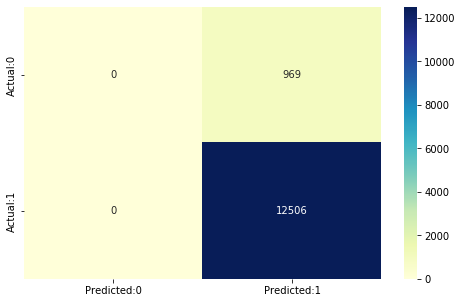

In [29]:
confusion_mat(LogReg_pipeline, new_inputs_test, y_test)

Improving the model with gridsearch

In [30]:
parameters = {
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__max_iter': [1000,1500]
}

#parameters_grid = {'classifier__estimator__n_estimators': [10, 20, 40]}

#f1 = make_scorer(f1_score , average='macro')
cv = GridSearchCV(LogReg_pipeline, param_grid=parameters)

In [31]:
# Find best parameters
cv.fit(new_inputs_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                              

In [32]:
#test model
performance_report(cv, new_inputs_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       969
           1       0.93      1.00      0.96     12506

    accuracy                           0.93     13475
   macro avg       0.46      0.50      0.48     13475
weighted avg       0.86      0.93      0.89     13475



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'tn': 0, 'fp': 969, 'fn': 0, 'tp': 12506}

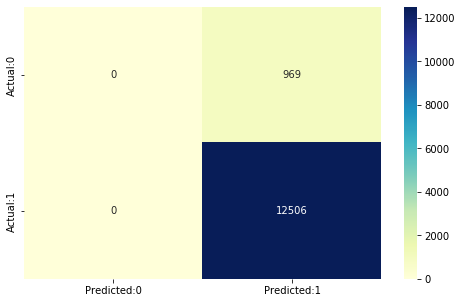

In [33]:
confusion_mat_with_gridsearch(cv, new_inputs_test, y_test)

In [34]:
optimised_model = cv.best_estimator_

In [35]:
optimised_model

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [36]:
# Pickle best model

with open('prosper_loan_model.pkl', 'wb') as f:
    pickle.dump(optimised_model, f)

### Interpreting the PD model

In [37]:
#print optimised_model.named_steps['clf'].coef_

In [38]:
optimised_model.named_steps['clf'].intercept_

array([3.85431444])

In [39]:
feature_name = new_inputs_train.columns.values

In [40]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(optimised_model.named_steps['clf'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', optimised_model.named_steps['clf'].intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,3.854314
1,ProsperRating (Alpha):A,-0.714939
2,ProsperRating (Alpha):B,-0.976637
3,ProsperRating (Alpha):C,-0.641563
4,ProsperRating (Alpha):D,-0.463067
5,ProsperRating (Alpha):E,0.406727
6,Term:12,-0.345794
7,ProsperScore:2-5,0.803845
8,ProsperScore:6-8,0.369364
9,ProsperScore:9-11,0.543952


### Evaluating and interpreting the model

In [41]:
def probability_default_df(model,X_true,y_true):
    """
    Function to generate probability of good borrowers on a model
    INPUT: Model, true data sets, that is X_true & y_true data sets
    OUTPUT: Prints the target test data and its corresponing probability of being a 
    good borrower 
    """
    y_hat_test = model.best_estimator_.predict(X_true)
    y_hat_test_proba = model.best_estimator_.predict_proba(X_true)
    y_hat_test_proba = y_hat_test_proba[: ][: , 1]
    
    y_test_temp = y_true
    df_actual_predicted_probs = pd.concat([pd.DataFrame(y_test_temp),
                                           pd.DataFrame(y_hat_test_proba)], axis = 1)


    df_actual_predicted_probs.columns = ['y_test', 'y_hat_test_proba']
    df_actual_predicted_probs.index = X_true.index
   
   

    return df_actual_predicted_probs
# Makes the index of one dataframe equal to the index of another dataframe.


    

In [42]:
def conf_mat(tr):
    """A function to give the model's confusion matrix for a given threshold.
    
    INPUT: tr = probability threshold
    """
    df = probability_default_df(cv, new_inputs_test, y_test)
    y_hat_test = cv.best_estimator_.predict(new_inputs_test)
    
    
    df['y_hat_test'] = np.where(df['y_hat_test_proba'] > tr, 1, 0)
    
    return pd.crosstab(df['y_test'], df['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])
    #pd.crosstab(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

   

In [43]:
#a look at the y_test train and predicted probabilities
df_predict_proba = probability_default_df(cv, new_inputs_test, y_test)
df_predict_proba.head()

,y_test,y_hat_test_proba
0,1,0.828632
1,1,0.838969
2,1,0.932718
3,1,0.969187
4,1,0.941022


In [44]:
x_test.shape

(13475, 77)

### Confusion Matrix

Earlier we saw the confusion matrix for our logistic regression model given as:

In [45]:
conf_mat(0.5)

Predicted,1
Actual,
0,969
1,12506


So here we have pricted the default confusion matrix in sklearn and how it works is that:
an indicator is defined,
- where every observation that has predicted probability greater than the threshold (tr) has a value of 1,
- and every observation that has predicted probability lower than the threshold has a value of 0.

Obviously, all observations that are actually good are predicted to be good, which is a good thing. On the other hand, all observations that are bad are predicted to be good with non predicted to be bad. 

This is a huge problem, 

- first we know our data is purely imbalanced with more than 92% of borrowers being good. Thus 
\begin{align}
\text{Accuracy} = \frac{TP+TN}{(TP+TN+FP+FN) } = \frac{12506}{12506+969}=92.8 \%
\end{align}

where 'TN'= cm[0, 0], 'FP'= cm[0, 1],'FN'= cm[1, 0], and  'TP'= cm[1, 1]}

it turns out under a threshold of 0.5, the model generates a lot of false positives; that is observations that are bad but are being classified as being good. Imagine what would happen if the model was used for making a decision such as granting loans. With this threshold, a lot of bad applicants would be given loans. This is completely unacceptable.

That's what happens when we keep the default threshold since very few people default on their loans. The regression learns that and classifies almost all cases as good.

Let us increase the threshold to 0.9


In [46]:
conf_mat(0.9)

Predicted,0,1
Actual,,
0,580,389
1,2773,9733


So here we have reduced the number of false positive predictions which also decreased the number of true positives.  But that implies that under this 0.9 threshold, a lender who uses ths model would be reducing the number of probability of defaults drastically, on the other hand, they would also be reducing the number of overall approved applications which may lead to losing business. 

### Comments

OK, what we have seen above is that overall accuracy is not the universal measure for an effective credit risk model. 

One of the more common ways to approach that is to see the rates of the false positive predictions and the rates of the true positive predictions for all possible thresholds in machine learning.
The Curve, which shows the rate of the true positive predictions, is called receiver operating characteristic (ROC)  curve or AUC curve.

Every point on that curve actually corresponds to one threshold point that would result in a different classification of good and bad. More specifically, each point from the AUC curve corresponds to a different confusion matrix based on a different classification threshold.

So let's plot the accuracy curve for our model.

### Receiver Operating Characteristic (ROC) / Area Under Curve (AUC)


In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

In [48]:
#roc_curve(df_actual_predicted_probs['y_test'], df_actual_predicted_probs['y_hat_test_proba'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.

In [49]:
def Roc_Curve(plot = True):
    """
    Function to plot ROC curve and print AUC 
    
    OUTPUT: Plots ROC and returns AUC. 
    """
    df = probability_default_df(cv, new_inputs_test, y_test)
    
    
    fpr, tpr, thresholds = roc_curve(df['y_test'], df['y_hat_test_proba'])
    if plot:
        plt.plot(fpr, tpr)
    # We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
    # thus plotting the ROC curve.
        plt.plot(fpr, fpr, linestyle = '--', color = 'k')
    # We plot a seconary diagonal line, with dashed line style and black color.
        plt.xlabel('False positive rate')
    # We name the x-axis "False positive rate".
        plt.ylabel('True positive rate')
    # We name the x-axis "True positive rate".
        plt.title('ROC curve')
    AUROC = roc_auc_score(df['y_test'], df['y_hat_test_proba'])
    # Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
    # from a set of actual values and their predicted probabilities.
    #print("Area under curve is: ")
    return round(AUROC,4)
    # We name the graph "ROC curve".



0.7408

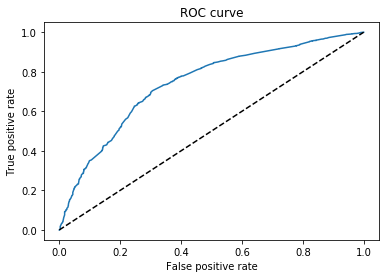

In [50]:
Roc_Curve()

### Comment

Well, and it's difficult to say because it mostly depends on our data.
Even a model that is built in an excellent way may not be very accurate just because the data provided
are not good enough.
That being said, a common skill for interpretation of area under the curve is this the model is bad 

- bad if AUC is between 50% and 60%
- poor if it is between 60% and 70%,
- fair if it is between 70% and 80% percent 
- good, if it's between 80% and 90%.
- excellent if it's between 90% and 100%

According to that criteria, we can say our model with AUC = 0.7408 is fair.

### Gini and Kolmogorov-Smirnov

#### Criteria for model performance of classification models


The first is the Gini coefficient, while the second Kolmogorov-Smirnov, they are well-established and widely accepted in the credit risk modeling community.

#### Gini

In [51]:
def Gini_performance(plot=True):
    """
    Function to generate probability of good borrowers on a model
    INPUT: Model, true data sets, that is X_true & y_true data sets
    OUTPUT: Prints the target test data and its corresponing probability of being a 
    good borrower 
    """
    df = probability_default_df(cv, new_inputs_test, y_test)
    #y_hat_test = cv.best_estimator_.predict(new_inputs_test)
    df = df.sort_values('y_hat_test_proba')
    df = df.reset_index()

    df['Cumulative N Population'] = df.index + 1
    # We calculate the cumulative number of all observations.
    # We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
    df['Cumulative N Good'] = df['y_test'].cumsum()
    # We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
    df['Cumulative N Bad'] = df['Cumulative N Population'] - df['y_test'].cumsum()
    # We calculate cumulative number of 'bad', which is
    # the difference between the cumulative number of all observations and cumulative number of 'good' for each row.
    
    df['Cumulative Perc Population'] = df['Cumulative N Population'] / (df.shape[0])
    # We calculate the cumulative percentage of all observations.
    df['Cumulative Perc Good'] = df['Cumulative N Good'] / df['y_test'].sum()
    # We calculate cumulative percentage of 'good'.
    df['Cumulative Perc Bad'] = df['Cumulative N Bad'] / (df.shape[0] - df['y_test'].sum())
    # We calculate the cumulative percentage of 'bad'.
    
    # Plot Gini
    if plot:
        plt.plot(df['Cumulative Perc Population'], df['Cumulative Perc Bad'])
    # We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
    # thus plotting the Gini curve.
        plt.plot(df['Cumulative Perc Population'], df['Cumulative Perc Population'], linestyle = '--', color = 'k')
    # We plot a seconary diagonal line, with dashed line style and black color.
        plt.xlabel('Cumulative % Population')
    # We name the x-axis "Cumulative % Population".
        plt.ylabel('Cumulative % Bad')
    # We name the y-axis "Cumulative % Bad".
        plt.title('Gini')
    # We name the graph "Gini".
    AUROC = Roc_Curve(plot=False)
    Gini = AUROC * 2 - 1
    # Here we calculate Gini from AUROC.
    return df, round(Gini,4)

0.4816

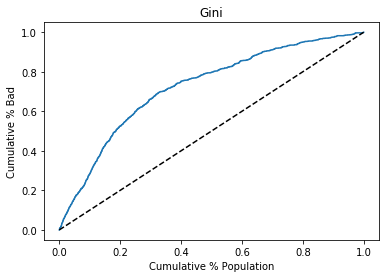

In [52]:
df, Gini = Gini_performance()
Gini

#### Kolmogorov-Smirnov

In [53]:
def Kolmog_Smir():
    # Plot KS
    #df = probability_default_df(cv, new_inputs_test, y_test)
    df, Gini = Gini_performance(plot=False)


    plt.plot(df['y_hat_test_proba'], df['Cumulative Perc Bad'], color = 'r',label="Bad Borrowers")
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
    plt.plot(df['y_hat_test_proba'], df['Cumulative Perc Good'], color = 'b',label="Good Borrowers")
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
    plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
    plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
    plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".
    plt.legend()
    KS = max(df['Cumulative Perc Bad'] - df['Cumulative Perc Good'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
    return round(KS,4)

0.3982

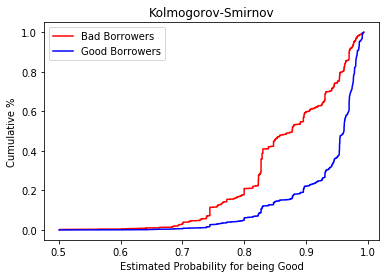

In [54]:
Kolmog_Smir()

#### Comment

We obtain a Kolmogorov Smirnov of 40%>20%, which is accepttable for a PD-model.

# Conclusion

It is far more important to know to what extent the outcome of interest can be explained by the available information. 

We analyzed posper loan data in this [notebook](http://localhost:8888/notebooks/Prosper%20Loan%20Data%20Analysis.ipynb#Overview), then we prepared our data [here](http://localhost:8888/notebooks/Forecasting%20credit%20risk%20using%20logistic%20regression.ipynb#ProsperScore) for our machine learning model. Finally in this notebook, we estimated and evaluated the Probability of Default model for the prosper loan data for year 2012-2013. 

While our data is highly imbalanced, we demonstrated that accuracy of the model is not the best as it tnds to predict more good borrowers than bad ones. However, considering other measures of evaluation for our PD-model, we find out that our model has a strong discrimatory power in separating good from bad borrowers. 